In [53]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.dates as mdates
sns.set_style('whitegrid')
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout,GRU
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from tensorflow.keras import optimizers, Model
import matplotlib.pyplot as plt
import math

# Load Data

In [54]:
import os
CURR_FOLDER_PATH = os.getcwd()
BASE_PATH = os.path.dirname(os.path.dirname(CURR_FOLDER_PATH))
DATA_PATH = os.path.join(BASE_PATH, 'Lulus/data')

In [55]:
df = pd.read_excel(DATA_PATH + '/Hargalagpasartradisionallagvariable.xlsx')
# Data yang digunakan yaitu Harga cabai Rawit dan Harga Bawang putih sebagai Barang Subtitusi Sudah dilakukan lag - 1 Minggu

In [56]:
df

,Tanggal,Harga Bawang Putih,Harga Cabai Merah,Harga Cabai Rawit
0,01/ 01/ 2018,-,-,-
1,08/ 01/ 2018,-,38300,-
2,15/ 01/ 2018,24300,42800,42600
3,22/ 01/ 2018,24200,37850,42700
4,29/ 01/ 2018,23100,38950,42600
...,...,...,...,...
308,27/ 11/ 2023,37450,80250,76600
309,04/ 12/ 2023,37600,94900,79150
310,11/ 12/ 2023,37200,99300,79100
311,18/ 12/ 2023,38050,85000,75550


# Statistical Analytics

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Tanggal             313 non-null    object
 1   Harga Bawang Putih  313 non-null    object
 2   Harga Cabai Merah   313 non-null    object
 3   Harga Cabai Rawit   313 non-null    object
dtypes: object(4)
memory usage: 9.9+ KB


In [58]:
df.shape

(313, 4)

In [59]:
df.replace('-', pd.NA, inplace=True)

In [60]:
missing_values = df.isnull().sum()
percentage_missing = (missing_values / df.shape[0]) * 100
print("Jumlah Missing Value per Kolom:")
print(missing_values)
print("\nPersentase Missing Value per Kolom:")
percentage_missing

Jumlah Missing Value per Kolom:
Tanggal               0
Harga Bawang Putih    9
Harga Cabai Merah     9
Harga Cabai Rawit     9
dtype: int64

Persentase Missing Value per Kolom:


Tanggal               0.000000
Harga Bawang Putih    2.875399
Harga Cabai Merah     2.875399
Harga Cabai Rawit     2.875399
dtype: float64

In [61]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/ %m/ %Y')
df['Bulan'] = df['Tanggal'].dt.to_period('M')
mean_values = df.groupby('Bulan').mean()


def fill_missing_with_mean(row):
    if pd.isna(row['Harga Bawang Putih']):
        row['Harga Bawang Putih'] = mean_values.loc[row['Bulan'], 'Harga Bawang Putih']
    if pd.isna(row['Harga Cabai Merah']):
        row['Harga Cabai Merah'] = mean_values.loc[row['Bulan'], 'Harga Cabai Merah']
    if pd.isna(row['Harga Cabai Rawit']):
        row['Harga Cabai Rawit'] = mean_values.loc[row['Bulan'], 'Harga Cabai Rawit']
    return row


df = df.apply(fill_missing_with_mean, axis=1)
print(df)

       Tanggal  Harga Bawang Putih  Harga Cabai Merah  Harga Cabai Rawit  \
0   2018-01-01        23866.666667       39475.000000       42633.333333   
1   2018-01-08        23866.666667       38300.000000       42633.333333   
2   2018-01-15        24300.000000       42800.000000       42600.000000   
3   2018-01-22        24200.000000       37850.000000       42700.000000   
4   2018-01-29        23100.000000       38950.000000       42600.000000   
..         ...                 ...                ...                ...   
308 2023-11-27        37450.000000       80250.000000       76600.000000   
309 2023-12-04        37600.000000       94900.000000       79150.000000   
310 2023-12-11        37200.000000       99300.000000       79100.000000   
311 2023-12-18        38050.000000       85000.000000       75550.000000   
312 2023-12-25        39050.000000       93066.666667       66350.000000   

       Bulan  
0    2018-01  
1    2018-01  
2    2018-01  
3    2018-01  
4    2018-01

In [62]:
df['Harga Cabai Merah'] = df['Harga Cabai Merah'].astype('float64')
df['Harga Bawang Putih'] = df['Harga Bawang Putih'].astype('float64')
df['Harga Cabai Rawit'] = df['Harga Cabai Rawit'].astype('float64')

In [63]:
import seaborn as sns

harga_merah_stats = df['Harga Cabai Merah'].describe()
print("\nStatistik Deskriptif Harga Cabai Merah:")
print(harga_merah_stats)

harga_putih_stats = df['Harga Bawang Putih'].describe()
print("\nStatistik Deskriptif Harga Bawang Putih:")
print(harga_putih_stats)

harga_rawit_stats = df['Harga Cabai Rawit'].describe()
print("\nStatistik Deskriptif Harga Cabai Rawit:")
print(harga_rawit_stats)



Statistik Deskriptif Harga Cabai Merah:
count       313.000000
mean      43092.092652
std       15493.651894
min       21750.000000
25%       31650.000000
50%       40800.000000
75%       49550.000000
max      109450.000000
Name: Harga Cabai Merah, dtype: float64

Statistik Deskriptif Harga Bawang Putih:
count      313.000000
mean     31311.648030
std       6546.352059
min      22400.000000
25%      27600.000000
50%      28700.000000
75%      34400.000000
max      73900.000000
Name: Harga Bawang Putih, dtype: float64

Statistik Deskriptif Harga Cabai Rawit:
count       313.000000
mean      44877.715655
std       17241.023349
min       22600.000000
25%       30950.000000
50%       42000.000000
75%       54250.000000
max      100750.000000
Name: Harga Cabai Rawit, dtype: float64


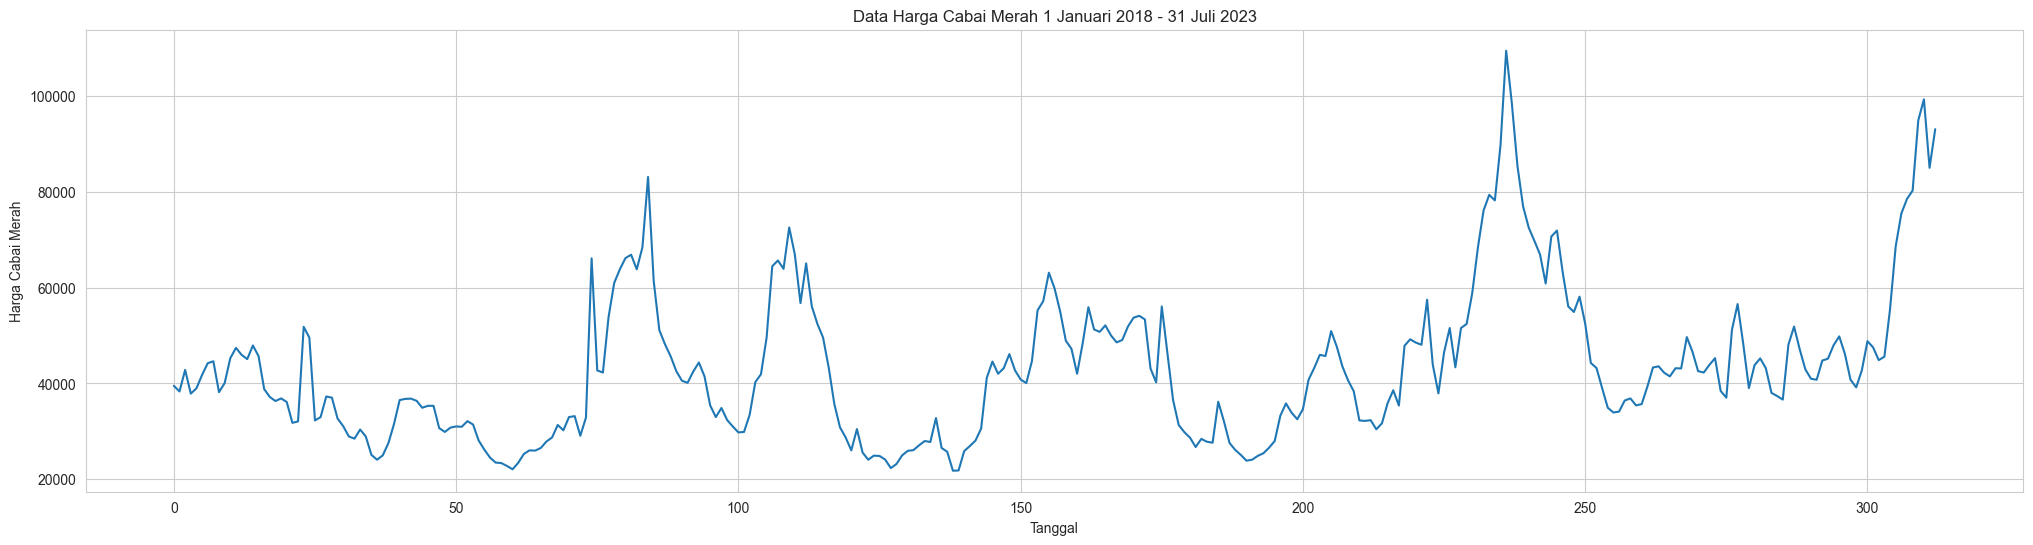

In [64]:
# Visualisasi
plt.figure(figsize=(25, 6))
plt.plot(df.index, df['Harga Cabai Merah'])
plt.title('Data Harga Cabai Merah 1 Januari 2018 - 31 Juli 2023')
plt.xlabel('Tanggal')
plt.ylabel('Harga Cabai Merah')
plt.show()

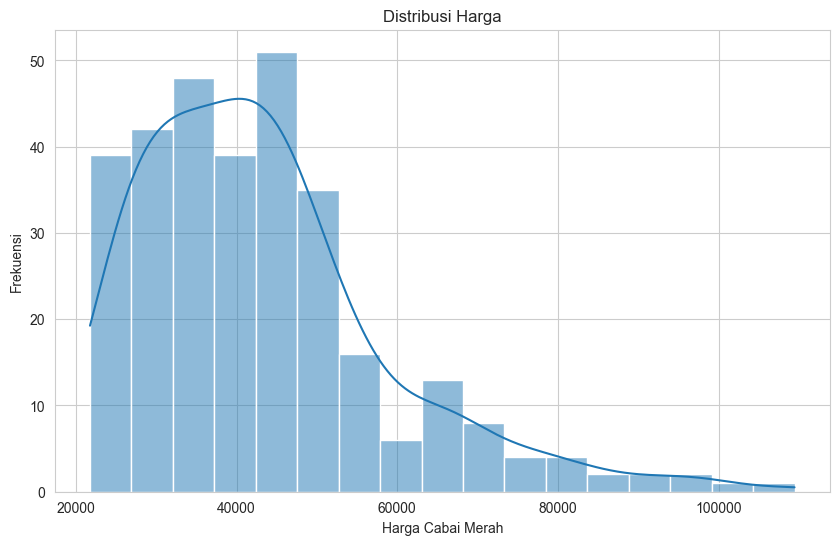

In [65]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Harga Cabai Merah'], kde=True)
plt.title('Distribusi Harga')
plt.xlabel('Harga Cabai Merah')
plt.ylabel('Frekuensi')
plt.show()

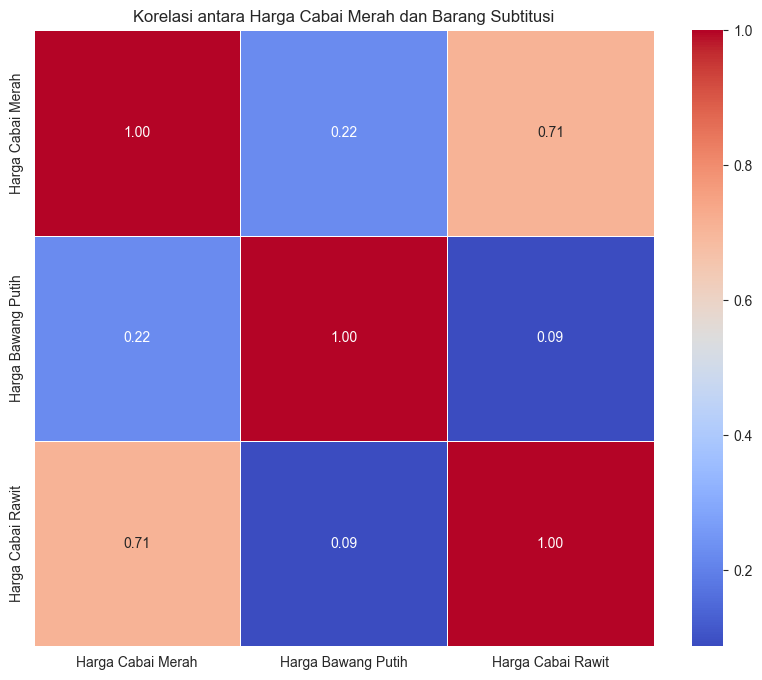

In [66]:
corr_with_target = df[['Harga Cabai Merah','Harga Bawang Putih','Harga Cabai Rawit']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Korelasi antara Harga Cabai Merah dan Barang Subtitusi')
plt.show()

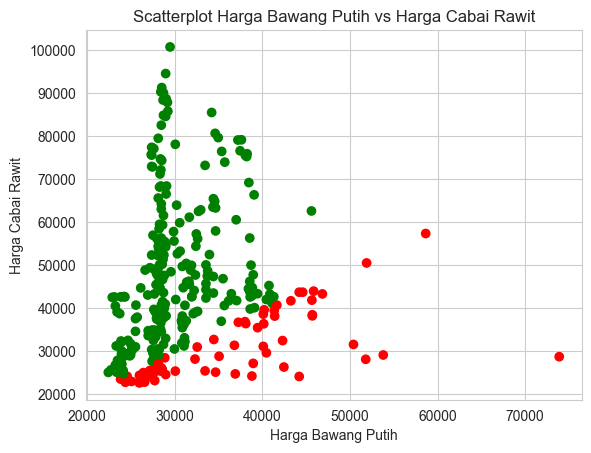

In [67]:
colors = ['red' if x > y else 'green' for x, y in zip(df['Harga Bawang Putih'], df['Harga Cabai Rawit'])]

plt.scatter(df['Harga Bawang Putih'], df['Harga Cabai Rawit'], c=colors)

plt.title('Scatterplot Harga Bawang Putih vs Harga Cabai Rawit')
plt.xlabel('Harga Bawang Putih')
plt.ylabel('Harga Cabai Rawit')
plt.show()

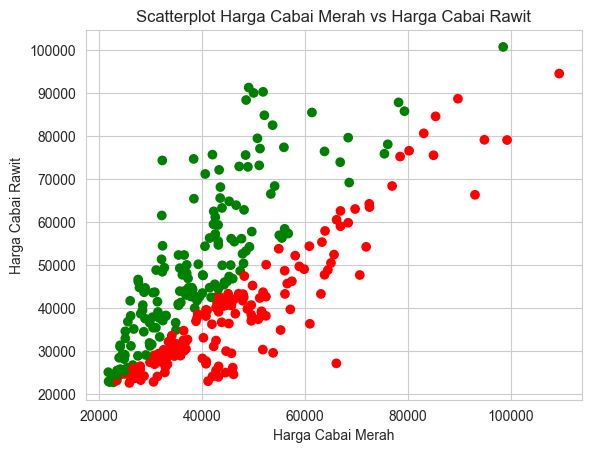

In [68]:
colors = ['red' if x > y else 'green' for x, y in zip(df['Harga Cabai Merah'], df['Harga Cabai Rawit'])]

plt.scatter(df['Harga Cabai Merah'], df['Harga Cabai Rawit'], c=colors)
plt.title('Scatterplot Harga Cabai Merah vs Harga Cabai Rawit')
plt.xlabel('Harga Cabai Merah')
plt.ylabel('Harga Cabai Rawit')
plt.show()

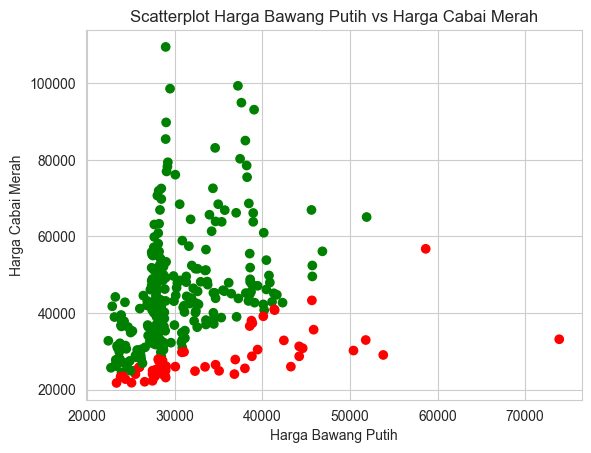

In [69]:
colors = ['red' if x > y else 'green' for x, y in zip(df['Harga Bawang Putih'], df['Harga Cabai Merah'])]

plt.scatter(df['Harga Bawang Putih'], df['Harga Cabai Merah'], c=colors)
plt.title('Scatterplot Harga Bawang Putih vs Harga Cabai Merah')
plt.xlabel('Harga Bawang Putih')
plt.ylabel('Harga Cabai Merah')
plt.show()

# Preprocessing Data


In [70]:
scaler_rr = MinMaxScaler(feature_range=(0, 1))
scaler_harga = MinMaxScaler(feature_range=(0, 1))
df['Harga Cabai Merah_Scaled'] = scaler_harga.fit_transform(df[['Harga Cabai Merah']])
df['Harga Bawang Putih_Scaled'] = scaler_rr.fit_transform(df[['Harga Bawang Putih']])
df['Harga Cabai Rawit_Scaled'] = scaler_rr.fit_transform(df[['Harga Cabai Rawit']])

# Split Data

In [71]:
selected_columns = ['Harga Cabai Merah_Scaled']
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)][selected_columns].values
        dataX.append(a)
        dataY.append(dataset[i + look_back:i + look_back + 1]['Harga Cabai Merah_Scaled'].values)
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], len(selected_columns)))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], len(selected_columns)))

# Pembuatan Model

In [72]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1), activation='relu'))
model.add(LSTM(units=64, activation='relu'))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(trainX, trainY, epochs=65, batch_size=64, verbose=1)


Epoch 1/65
4/4 [==============================] - 1s 3ms/step - loss: 0.0812
Epoch 2/65
4/4 [==============================] - 0s 2ms/step - loss: 0.0776
Epoch 3/65
4/4 [==============================] - 0s 2ms/step - loss: 0.0743
Epoch 4/65
4/4 [==============================] - 0s 2ms/step - loss: 0.0709
Epoch 5/65
4/4 [==============================] - 0s 2ms/step - loss: 0.0674
Epoch 6/65
4/4 [==============================] - 0s 2ms/step - loss: 0.0639
Epoch 7/65
4/4 [==============================] - 0s 2ms/step - loss: 0.0603
Epoch 8/65
4/4 [==============================] - 0s 2ms/step - loss: 0.0567
Epoch 9/65
4/4 [==============================] - 0s 2ms/step - loss: 0.0532
Epoch 10/65
4/4 [==============================] - 0s 2ms/step - loss: 0.0496
Epoch 11/65
4/4 [==============================] - 0s 2ms/step - loss: 0.0459
Epoch 12/65
4/4 [==============================] - 0s 2ms/step - loss: 0.0420
Epoch 13/65
4/4 [==============================] - 0s 2ms/step - loss: 0.

In [73]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 50)             10400     
                                                                 
 lstm_5 (LSTM)               (None, 64)                29440     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [74]:
predictions = model.predict(testX)
predictions = scaler_harga.inverse_transform(predictions)
testY = scaler_harga.inverse_transform(testY)

2/2 [==============================] - 0s 2ms/step


In [75]:
trainY = scaler_harga.inverse_transform(trainY)

In [76]:
df_test = pd.DataFrame({'Actual': np.squeeze(testY), 'Predicted': np.squeeze(predictions)})
df_test.head(30)

,Actual,Predicted
0,44250.0,49280.261719
1,43200.0,42551.246094
2,39000.0,41741.410156
3,34900.0,38614.085938
4,33900.0,35728.304688
5,34100.0,35048.640625
6,36400.0,35183.828125
7,36850.0,36765.410156
8,35400.0,37080.707031
9,35650.0,36071.644531


In [77]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df.set_index('Tanggal', inplace=True)
df.sort_index(inplace=True)
df.index = pd.to_datetime(df.index)

# Hasil Akhir

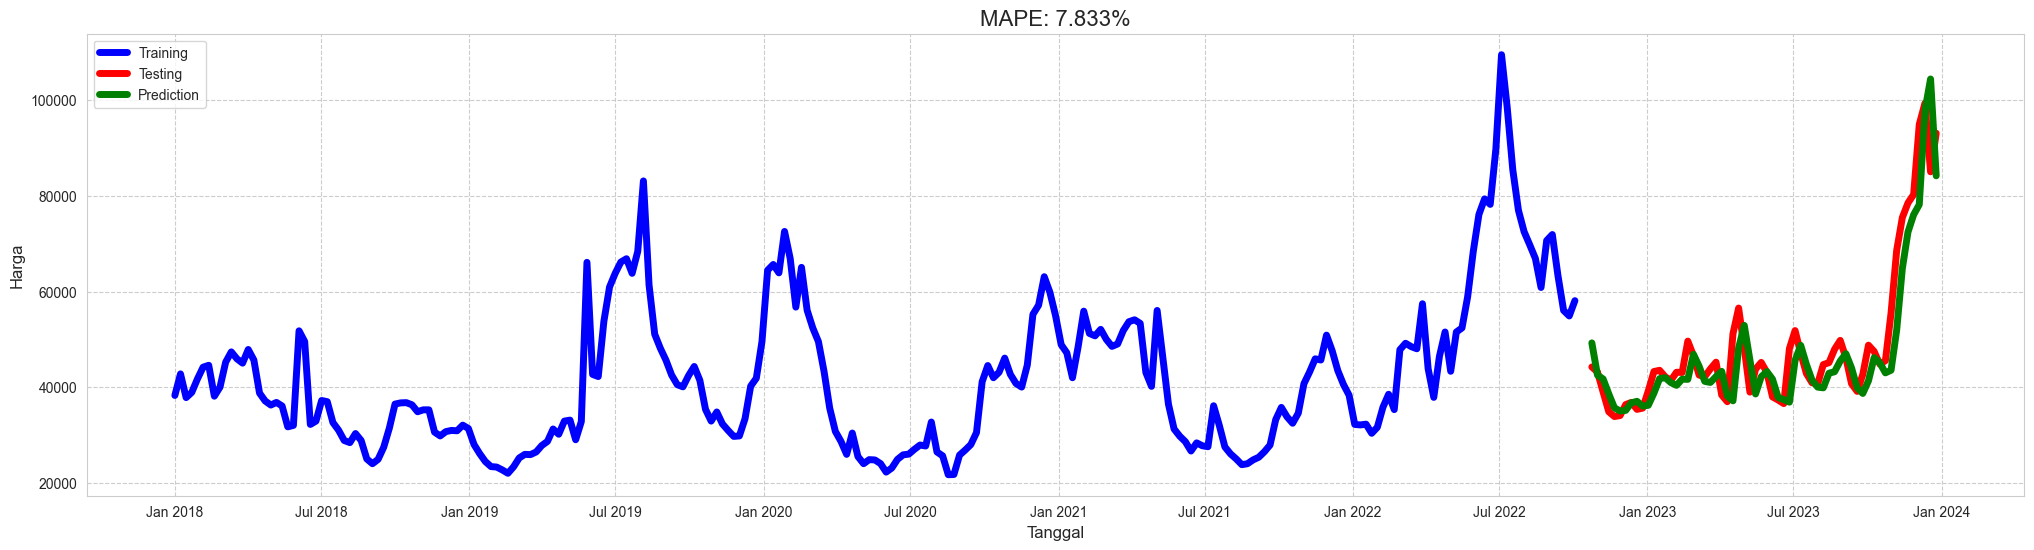

In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib.dates import MonthLocator, DateFormatter
mape = mean_absolute_percentage_error(testY, predictions)*100

plt.figure(figsize=(25, 6))
plt.plot(df.index[:len(trainY)], trainY, label='Training', marker='', color='blue', linestyle='-', linewidth=5)
plt.plot(df.index[-len(testY):], testY, label='Testing', marker='', color='red', linestyle='-', linewidth=5)
plt.plot(df.index[-len(predictions):], predictions, label='Prediction', marker='', color='green', linestyle='-', linewidth=5)
plt.title(f'MAPE: {mape:.3f}%', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga', fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()

locator = MonthLocator(bymonth=[1, 7])
formatter = DateFormatter('%b %Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xticks(rotation=0)
plt.show()
